# Censored Corpus Hashtags

This notebook is a duplicate of `hashtags.ipynb`, except there is an additional section here to censor offensive languge from the top 25 hashtags for each label.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
# packages for NLP preprocessing
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle

## Load in `raw_df` with Uncleaned Tweets

In [2]:
# showing the whole tweet column
pd.set_option('max_colwidth', 280)

In [4]:
# importing raw tweets before they were cleaned
raw_df = pd.read_pickle(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Datasets\raw_tweets_df.pkl')

In [6]:
raw_df.head(5)

,total_votes,hate_speech_votes,other_votes,label,tweet
0,3,1,3,0,kindly say bickering to kikuyus and kalenjins. the rest of the country with him.
1,3,1,3,0,kindly remind them that we do not have thoroughbred kikuyus but rather a mix of
2,3,1,3,0,kindly look at moses' statement. where has he said i will kill u. hmmmm.....guys stop putting words which weren't spoken.saying nitamzima mimi doesn't mean hr is gona kill him. bt deal with him until he silences thru law
3,3,1,3,0,kindly like this page>>>wtf fun facts maasai are the only tribe in kenya mentioned in the bible...4 exclusive...
4,3,1,3,0,kindly kikuyus humble yourselves in 2022 and take this man back to sigoi where he belongs.


## Filtering Out Hashtags From Raw Tweets

In [7]:
raw_df['hashtags'] = raw_df['tweet'].str.extract('([^&]#[\w]+)', expand=False).str.strip()

In [10]:
raw_df.head(5)

,total_votes,hate_speech_votes,other_votes,label,tweet,hashtags
0,3,1,3,0,kindly say bickering to kikuyus and kalenjins. the rest of the country with him.,NaN
1,3,1,3,0,kindly remind them that we do not have thoroughbred kikuyus but rather a mix of,NaN
2,3,1,3,0,kindly look at moses' statement. where has he said i will kill u. hmmmm.....guys stop putting words which weren't spoken.saying nitamzima mimi doesn't mean hr is gona kill him. bt deal with him until he silences thru law,NaN
3,3,1,3,0,kindly like this page>>>wtf fun facts maasai are the only tribe in kenya mentioned in the bible...4 exclusive...,NaN
4,3,1,3,0,kindly kikuyus humble yourselves in 2022 and take this man back to sigoi where he belongs.,NaN


In [9]:
raw_df.shape

(50175, 6)

In [11]:
raw_df.hashtags.isna().sum()

27051

#### Only 43.593% of the tweets have hashtags on them 

In [12]:
# dropping tweet rows with no hashtags
raw_df.dropna(inplace=True)

In [13]:
raw_df.shape

(23124, 6)

In [14]:
raw_df.reset_index(inplace=True)

## New Dataframe with Essential Columns

In [15]:
hashtags_df = raw_df[['label', 'hashtags']].copy()

In [16]:
hashtags_df.head()

,label,hashtags
0,0,#ripenglish
1,0,#kenyapoll
2,0,#resist
3,0,#whataboutthevictims
4,0,#railainnakuru


## Round 2 Cleaning
removing any characters before the #

In [17]:
hashtags_df['hashtags_2'] = hashtags_df['hashtags'].str.extract('(#[\w]+)', expand=False).str.strip()

In [18]:
hashtags_df.head()

,label,hashtags,hashtags_2
0,0,#ripenglish,#ripenglish
1,0,#kenyapoll,#kenyapoll
2,0,#resist,#resist
3,0,#whataboutthevictims,#whataboutthevictims
4,0,#railainnakuru,#railainnakuru


## Censoring Top 25 Hashtags


In [19]:
# # iteratiively censoring words
#re-edit the words

hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('faggots','f**gots')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('faggot','f**got')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('shittmybosssays','s**tmybosssays')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('hesgay','hesg*y')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('pussy','p**sy')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('bitch','b**ch')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('redskins','r**skins')
hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace('hoe','h*e')

In [20]:
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n***a', 'nigger':'ni**er', 'ass':'a**', 'hoe':'h**', 'hoes':'h**s', 'faggot':'fa***t', 'faggots':'fa***ts', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f**', 'shit':'sh*t', 'hesgay':'hesg*y','redskins':'r**skins',}

for k, v in replacements.items():
    hashtags_df['hashtags_2'] = hashtags_df['hashtags_2'].str.replace(k, v)

## Top Hashtags for Each Category

In [21]:
# creating new dfs for each classification
# hate speech
df_freq_hate = hashtags_df[hashtags_df['label']==1]
# not hate speech
df_freq_not_hate = hashtags_df[hashtags_df['label']==0]

In [22]:
# pulling out the hashtags column for raw tweets
hashtag_hate = df_freq_hate['hashtags_2']
hashtag_not_hate = df_freq_not_hate['hashtags_2']

In [23]:
# exact amount of hashtags in hate speech
total_vocab_hate = set()
for comment in hashtag_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

38

In [25]:
# exact amount of hashtags in not hate speech
total_vocab_NOT_hate = set()
for comment in hashtag_not_hate:
    total_vocab_NOT_hate.update(comment)
len(total_vocab_NOT_hate)

40

## Most Common Hashtags in Each Category

In [27]:
import collections
from collections import Counter

# list of all words across hate speech tweets
df_hate_count = list(df_freq_hate['hashtags_2'])
# create counter
hate_hashtag = collections.Counter(df_hate_count)
# top 10 hate speech tweet hashtags
hate_hashtag.most_common(31)

[('#luolivesmatter', 52),
 ('#noreformsnoelections', 19),
 ('#killallkikuyustoshuntribalism', 12),
 ('#kikuyus', 8),
 ('#stopethniccleansing', 8),
 ('#arrestkimaningunjiri', 7),
 ('#kot', 7),
 ('#uon', 7),
 ('#railareturns', 6),
 ('#norailanopeace', 6),
 ('#electionsboycottke', 6),
 ('#arrestgracemurewa', 5),
 ('#railapresser', 5),
 ('#tribalism254', 5),
 ('#corddemos', 5),
 ('#resist', 5),
 ('#fact', 4),
 ('#stopuhuruswardogs', 4),
 ('#railathewardogsince82', 4),
 ('#railathetribalchief', 4),
 ('#ripmsando', 4),
 ('#tanoterror', 4),
 ('#moseskuria', 4),
 ('#iebcdemos', 4),
 ('#stopkisumukillings', 4),
 ('#nowweknow', 3),
 ('#hatespeech', 3),
 ('#ballot2017', 3),
 ('#nasa', 3),
 ('#39', 3),
 ('#handsoffmoiuniversity', 3)]

In [29]:
# list of all words across NON hate speech tweets
df_not_hate_count = list(df_freq_not_hate['hashtags_2'])
# create counter
not_hate_hashtag = collections.Counter(df_not_hate_count)
# top 10 hate speech tweet hashtags
not_hate_hashtag.most_common(31)

[('#noreformsnoelections', 3249),
 ('#luolivesmatter', 1455),
 ('#ripmsando', 1239),
 ('#electionsboycottke', 980),
 ('#wembeniuleule', 833),
 ('#railapresser', 789),
 ('#hatespeech', 532),
 ('#moseskuria', 516),
 ('#uhurueurothieves', 457),
 ('#f**iawote', 411),
 ('#tribalism254', 345),
 ('#tanoterror', 340),
 ('#democracyorsecession', 292),
 ('#norailanopeace', 289),
 ('#choreaukabila', 218),
 ('#railathetribalchief', 217),
 ('#kenyapoll', 210),
 ('#arrestkimaningunjiri', 206),
 ('#shutmutahingunyiup', 198),
 ('#githeriman', 169),
 ('#railathewardogsince82', 160),
 ('#electionske2017', 156),
 ('#vifarangavyakompyuta', 139),
 ('#pundaamechoka', 134),
 ('#stopuhuruswardogs', 132),
 ('#mundukhumundu', 124),
 ('#freenyakundi', 108),
 ('#nowweknow', 94),
 ('#kenya', 71),
 ('#operationtimua', 70),
 ('#wakoranetwork', 69)]

## Frequency Distribution Graph

In [30]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_hashtag.most_common(25)]
hate_bar_words = [x[0] for x in hate_hashtag.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_hashtag.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_hashtag.most_common(25)]

In [31]:
# set the color of the bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

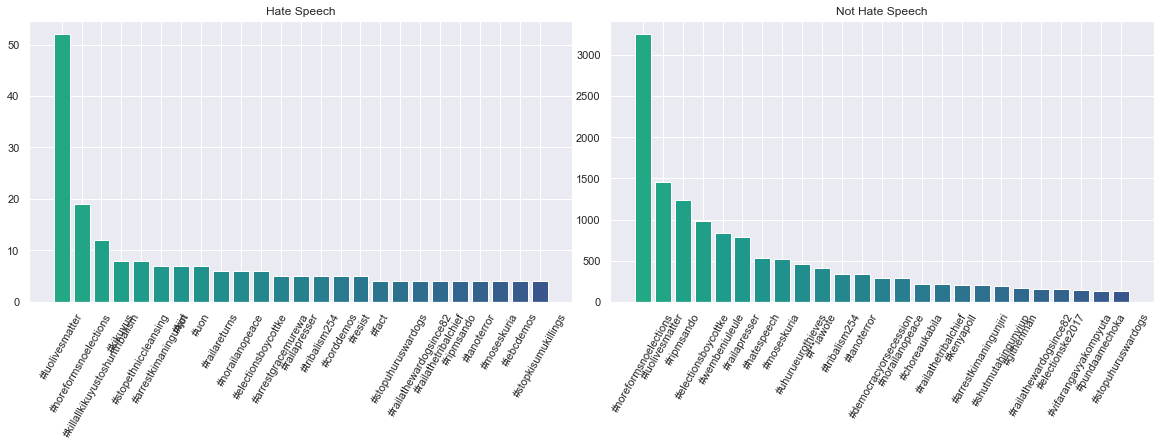

In [33]:
# top 25 hashtags for each label
new_figure = plt.figure(figsize=(16,6))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)
# generating a bar chart on each axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)

plt.savefig(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\visualizations\word count bar graphs.png')
plt.show()

## Word Clouds - Top 31 Hashtags for Each Label

In [34]:
from wordcloud import WordCloud
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

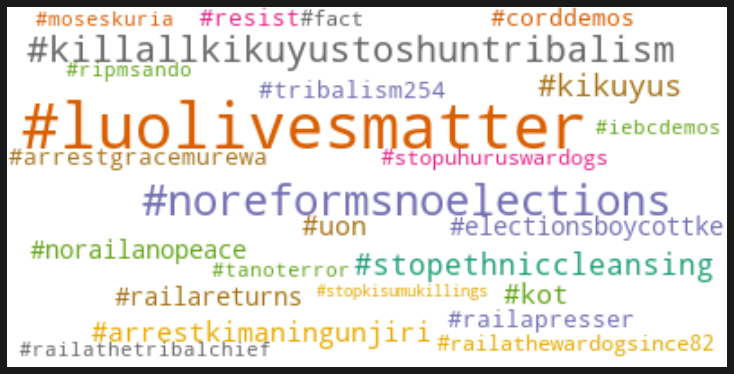

In [38]:
# create the word cloud for hate speech
hate_wordcloud = WordCloud(colormap='Dark2', background_color='white', random_state=16).generate_from_frequencies(hate_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(10,6), facecolor='k')
plt.imshow(hate_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.savefig(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\visualizations\satire_wordcloud.png')

plt.show()

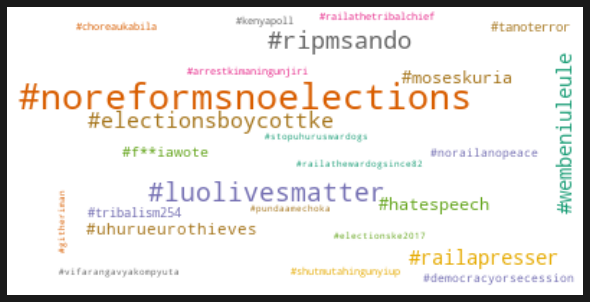

In [39]:
# create the word cloud for NOT hate speech
not_hate_wordcloud = WordCloud(colormap='Dark2', background_color='white', random_state=16).generate_from_frequencies(not_hate_dict)

plt.figure(figsize=(8,6), facecolor='k')
plt.imshow(not_hate_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\visualizations\not_satire_wordcloud.png')

plt.show()

## Joining Word Clouds

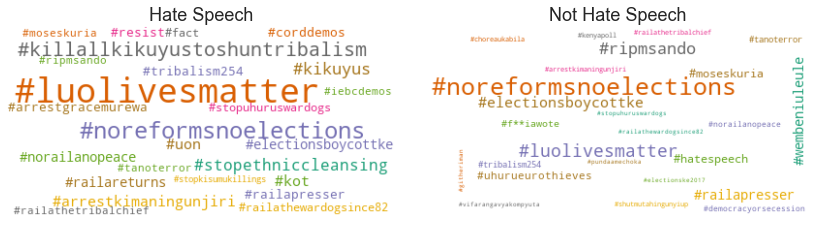

In [42]:
# new figure
f = plt.figure(figsize=(12,10))

# hate speech word cloud
f.add_subplot(1,2, 1)
plt.imshow(hate_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Speech', fontsize=18)

# not hate speech word cloud
f.add_subplot(1,2, 2)
plt.imshow(not_hate_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Hate Speech', fontsize=18)

# setting spacing between graphs
plt.tight_layout(pad=3)

plt.savefig('C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\visualizations\censored_top_hashtags.png', bbox_inches = "tight", pad_inches=.5)

Most of these hashtags don't provide much meaning, but some of them do. For instance, #teabagger and #tcot are hashtags used among Alt-Right communities. #teabagger refers to those who idenitify with the Tea Party, which is primariily (but not exclusively) associated with the Repubclican Party. And #tcot stands for "Top Conservatives On Twitter."

It could be expected that those hashtags contain hate speech or offensive language. Others are simply pop culture references, such as #Scandal the TV show or #vote5sos refering to the boy band.

Overall, we can reccomend that Twitter closely monitors these hashtags for potential posts containing hate speech or even regular offensive language.